In [1]:
import numpy as np
import random
from DeepESN import DeepESN
from utils import MSE, load_chest, select_indexes, load_MG
from sklearn.model_selection import ParameterGrid
import copy
import csv
import time

class Struct(object): pass

np.random.seed(7)
random.seed(7)

In [2]:
# trains the ESN by initializing it, computing all states, and then performing SVD for Wout
def train(Nr, Nl, reg, transient, rhos, lis, iss, con):
    configs = Struct()
 
    configs.rhos = rhos
    configs.lis = lis
    configs.iss = iss

    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 0 # deactivate pre-train

    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = con 

    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)

    deepESN = DeepESN(Nu, Nr, Nl, configs)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)
        
    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)
    
    deepESN.trainReadout(train_states, train_targets, reg)

    return score(deepESN, train_states, test_states, test_targets), test_targets[0].tolist()

In [3]:
# computes self fed and signal fed output data
def score(deepESN, train_states, test_states, test_targets):
    #compute error SIGNAL FED
    test_states_std = copy.deepcopy(test_states)
    test_outputs_std = deepESN.computeOutput(test_states_std)
    test_error_std = MSE(test_outputs_std, test_targets)

    #compute error SELF FED
    test_outputs = []
    state = [train_states[0][:,-1:]] #set last training state as initial state
    output = [np.array(deepESN.computeOutput(state))] #set last training output as initial output
    for t in range(len(test_states[0][0])):
        state = deepESN.computeState(inputs=output, DeepIP=0, initialStates=state[0])
        output = deepESN.computeOutput(state)
        test_outputs.append(output[0][0])
        output = [np.array(output)]

    test_error = MSE(np.array(test_outputs), np.array(test_targets))
    return test_error, test_outputs, test_error_std, test_outputs_std[0].tolist()

In [4]:
#construct parameter grid

#set parameter ranges for sweep
parameters = {
    "Nr": [10, 100, 200],               # number of recurrent units
    "Nl": [1, 2, 5, 10],                # number of recurrent layers
    "reg": [0.01, 0.1, 1.0, 10],        # regularization of svd
    "transient": [1000],                # washout
    "rhos": [0.8, 1.0, 1.2, 3.0, 5.0],  # set spectral radius for all recurrent layers
    "lis": [0.1, 0.2, 0.5],             # set leaky rate for all recurrent layers
    "iss": [1.0],                       # set input scale for all recurrent layers
    "con": [0.2, 0.5, 1.0],             # connectivity of recurrent matrix
    ".sampling": [1] #, 10, 30]         # set step size for sampling, 1 is no sampling. be careful not to make dataset too small
}

data_size = 20000 # pick dataset length to run parameter sweep on

if 640640/max(parameters[".sampling"]) < data_size:
    print("WARNING: highest sampling rate means that resulting dataset is smaller than data_size. \n")

print("Training data length: " + str(int(data_size*0.8)) + "  Validating data length: " + str(int(data_size*0.2)))

# construct parameter grid
search_space = ParameterGrid(parameters)
print("number of models to be swept over: " + str(len(search_space)))
for i in range(10):
    print(search_space[i])
    
#turn full parameter grid to list.
search_space_list = []
for i in range(len(search_space)):
    search_space_list.append(search_space[i])

# sort by sampling for more efficient training.
search_space_list = sorted(search_space_list, key=lambda k: k['.sampling'])    

Training data length: 16000  Validating data length: 4000
number of models to be swept over: 2160
{'transient': 1000, 'rhos': 0.8, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 3.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 5.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 0.8, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr'

In [5]:
# OPTIONAL: shorten paramgrid for pipeline testing
search_space_short = []
for i in range(5):
    index = round(random.random() * (len(search_space)-1))
    search_space_short.append(search_space[index])
    
search_space_short = sorted(search_space_short, key=lambda k: k['.sampling'])
search_space = search_space_short

print("models to be swept over: " + str(len(search_space)))

models to be swept over: 5


In [29]:
# OPTIONAL: filter best performing models from the search space and add seed range
best_models = [437, 577, 582, 726, 731, 773, 812, 933, 984, 988, 993, 999, 1036, 1141, 1207, 1331, 1336, 1368, 1416, 1431, 1456, 1516, 1528, 1533, 1576, 1597, 1787, 1876, 1943, 1948, 1953, 1995, 2037, 2056, 2069, 2156, 2157]
models = []

for model in best_models:
    for i in range(10):
        search_space[model]['seed'] = i
        models.append(search_space[model].copy())
    
search_space = models
print(len(search_space))
search_space[:3]


IndexError: list index out of range

In [7]:
# run the parameter sweep
start = time.time()
results = []
targets = []
previous = None

for i, args in enumerate(search_space):
    # set seed if necessary
    if 'seed'in args:
        np.random.seed(args['seed'])
        random.seed(args['seed'])
    
    if args[".sampling"] != previous:
        # update dataset with new sampling rate only at first occasion, for efficiency
        dataset, Nu, TR_indexes, VL_indexes, TS_indexes = load_chest('datasets', data_size, args[".sampling"])
        # dataset, Nu, TR_indexes, VL_indexes, TS_indexes = load_MG('datasets')
        
    output, test_targets = train(Nr=args['Nr'], Nl=args['Nl'], reg=args['reg'], transient=args['transient'], rhos=args['rhos'], lis=args['lis'], iss=args['iss'], con=args['con'])
    results.append(output)
    if args[".sampling"] != previous:
        # store target data for every sampling rate 
        targets.append([args[".sampling"], test_targets])
        previous = args[".sampling"]
    if i % 500 == 0:
        print(str(i/len(search_space_short)*100) + '%')

print("average time taken: " + str((time.time()-start)/len(search_space_short)))

input length =  19999
.7 =  13999
.8 =  15999
-1 =  19998
Done loading data
0.0%
average time taken: 2.7158719539642333


In [11]:
# csv export of output data to be able to do analysis independent of training
keys = []
for key in search_space_short[0].keys():
    keys.append(key)
keys.append("MSE")
keys.append("outputs")
keys.append("MSE_std")
keys.append("outputs_std")

header = keys

with open('results_ECG.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(header)

    for i in range(len(search_space_short)):
        vals = []
        for val in search_space_short[i].values():
            vals.append(val)
        for j in range(len(results[0])):
            vals.append(results[i][j])
        write.writerow(vals)

        
with open('targets_ECG.csv', 'w') as f:
    write = csv.writer(f)
    header = ["sampling rate", "test_targets"]
    write.writerow(header)
    
    for row in targets:
        write.writerow(row)


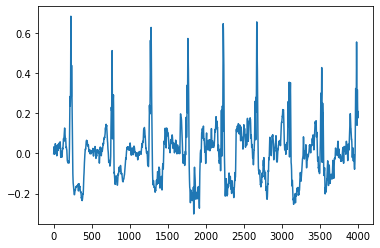

In [19]:
import matplotlib.pyplot as plt

# results[1][1]
plt.plot(targets[0][1][0])

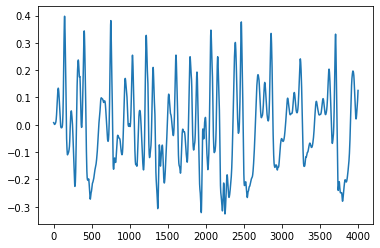

In [20]:
plt.plot(results[7][1])